In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [2]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [3]:
# hi_maps= np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_hi_maps.npy")
# noise_maps= np.load("/home/urwa/MASS_Thesis/Thesis/noise_nf.npy")
# ff=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_ff_maps.npy")
# sync=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_sync_maps.npy")
ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_hi_maps.npy")
noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")
hi_maps.shape
fgds=ff+sync/1e6
cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)
cl_noise= compute_covariance(noise_maps, lmax, almsize, nfreqs)
cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [4]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [5]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
*_,noise_binned= bin_spectra(cl_noise, 10)
*_, fgds_binned= bin_spectra(cl_fgds, 10)
total=hi_maps + noise_maps[:54]
cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
*_, chat_binned= bin_spectra(cl_hat, 10)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [142]:
def model_covariance(F, P_b,n_bins):
    
    # F: (N_channels, r), P_b: (r, r), C_HI & C_noise: (N_channels, N_channels)
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b]= np.dot(F,np.dot(P_b[b], F.T))
    return C_b


def params_1(freqs, A,n):
    """
    Generate parameters (F) for the model.

    Parameters:
    ----------
    freqs : np.ndarray
        Frequencies in MHz.
    
    A : float
        Amplitude of the power spectrum.
    n : float
        Power law index for the angular power spectrum.

    Returns:
    -------
    params : np.ndarray
        Parameter F dependent on frequency for the model.
    """
    
    F= np.zeros((len(freqs), 1))
    r=1
    for i in range (nfreqs):
        F[i] = np.log10(A) + n*np.log10(freqs[i])

    return np.log10(np.abs(F))


In [52]:
def log_poly_model(ell, *coeffs):
    log_ell = np.log10(ell)
    powers = np.vstack([log_ell**k for k in range(len(coeffs))]) #matrix of Cls for k polynomials
    return np.dot(coeffs, powers)
from scipy.optimize import curve_fit

log_ell = np.log10(leff)
smooth_cl=np.zeros((len(leff), nfreqs))
for i in range (nfreqs):
    log_cl = np.log10(hi_binned[:,i,i])
    
    popt, _ = curve_fit(log_poly_model, log_ell, log_cl, p0=np.ones(7)) #initial coefficient guess of ones of size k
    smooth_cl[:,i] = 10**log_poly_model(log_ell, *popt)


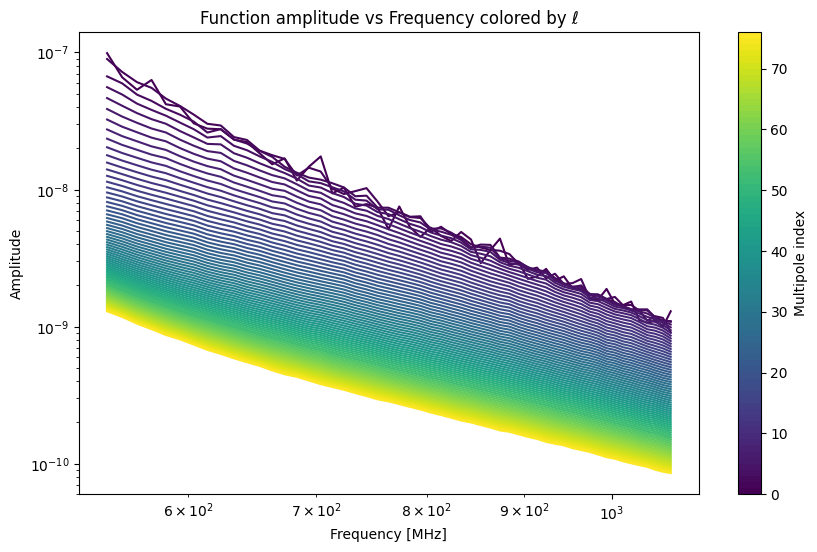

In [143]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 6))

cmap = plt.colormaps['viridis'].resampled(len(leff))
norm = mcolors.Normalize(vmin=0, vmax=len(leff))

for ell in range(len(leff)):
    ax.plot(freqs[:-1], smooth_cl[ell], color=cmap(norm(ell)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)  # Pass the figure and ax explicitly
cbar.set_label('Multipole index')

ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Amplitude')
ax.set_title('Function amplitude vs Frequency colored by ℓ')
plt.loglog()
plt.show()


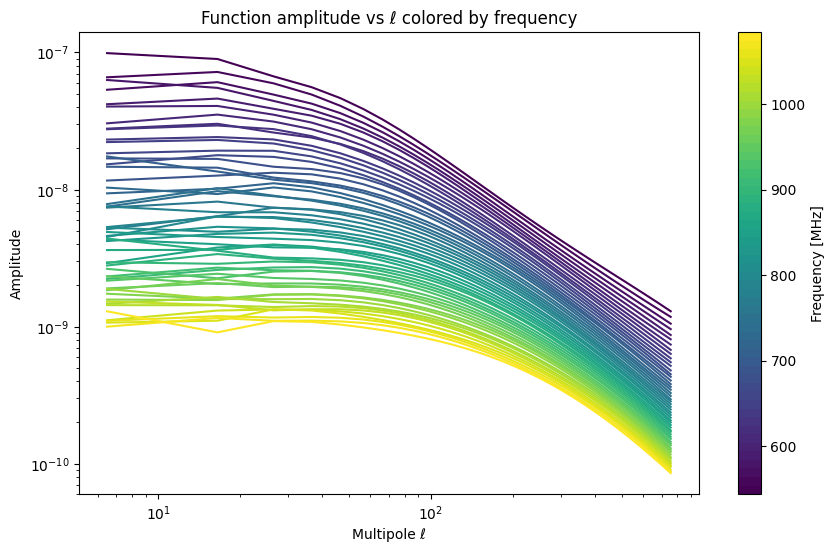

In [110]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 6))

# Define colormap
cmap = plt.colormaps['viridis'].resampled(len(freqs) - 1)
norm = mcolors.Normalize(vmin=freqs[0], vmax=freqs[-1])  # freqs[:-1]

# Plot each frequency channel as a separate line, colored by freq
for idx, freq in enumerate(freqs[:-1]):
    ax.plot(leff, smooth_cl[:,idx], color=cmap(norm(freq)))

# Create ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar for frequency
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Frequency [MHz]')

# Labels
ax.set_xlabel('Multipole ℓ')
ax.set_ylabel('Amplitude')
ax.set_title('Function amplitude vs ℓ colored by frequency')
plt.loglog()
plt.show()


[]

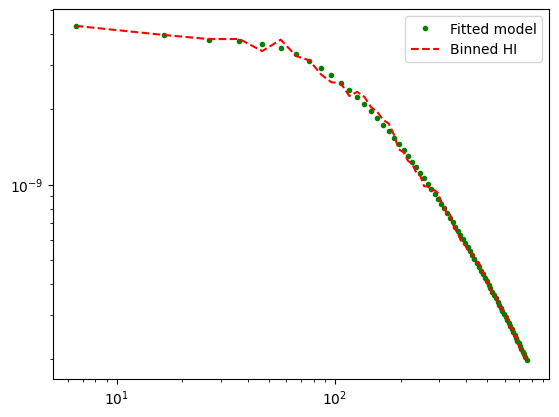

In [27]:
plt.plot(leff,smooth_cl, 'g.', label='Fitted model')
plt.plot(leff,hi_binned[:,30,30], 'r--', label='Binned HI')
plt.legend()
plt.loglog()

In [158]:
f=50

(76, 1, 1)
(54, 1)
(76, 54, 54)


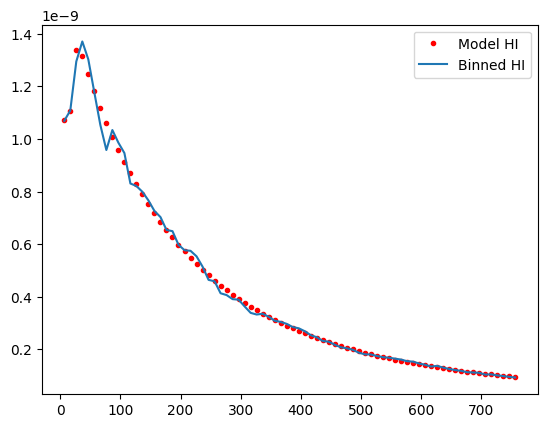

In [159]:
F_1= params_1(freqs[:-1],1e-7, -1)
P_fit=np.reshape(smooth_cl[:,f],(nbins,1,1))
F_fit=np.reshape(F_1,(nfreqs,1))
print(P_fit.shape)
print(F_fit.shape)
params_fit = np.concatenate([F_fit.flatten(), P_fit.flatten()])
model_fit=model_covariance(F_fit, P_fit, nbins)
print(model_fit.shape)
plt.plot(leff,model_fit[:,f,f],'r.',label='Model HI')
plt.plot(leff,hi_binned[:,f,f], label='Binned HI')
plt.legend()

In [138]:
# Check recovery
F_re = params_fit[:nfreqs * 1].reshape((nfreqs, 1))
P_b_re = params_fit[nfreqs * 1:].reshape((nbins, 1, 1))
print(F_re.shape)
print(P_b_re.shape)
print(F_re.size)
print(P_b_re.size)
np.allclose(F_fit, F_re)  # should return True
np.allclose(P_fit, P_b_re)  # should return True


(54, 1)
(76, 1, 1)
54
76


True

In [139]:
def smica(params, empirical,  n_bins, nfreqs, r):
    
    # Reshape the flattened params back into F_init and P_b_init
    
    F_i = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])

        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm  # symmetric scaling"""
    
    
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
                
    # === Compute the cost function ===            
    cost=0
    # model=np.zeros((n_bins, nfreqs, nfreqs))
    # model_inv=np.zeros((n_bins, nfreqs, nfreqs))
    
    # term=np.zeros(n_bins)
    for b in range(n_bins):
        model=  np.dot(F_i, np.dot(P_b[b], F_i.T))
        model_inv= np.linalg.inv(model)
        
        sign, logdet= np.linalg.slogdet(np.dot(empirical[b],model_inv))
        trace=np.trace(np.dot(empirical[b] , model_inv))
        
        term = -logdet + trace-nfreqs
        cost += term
        
    return cost


In [140]:
def jacobian_2(params, empirical, n_bins, nfreqs, r):
    
    delta_ell=10
    # Reshape the flattened params back into F_init and P_b_init
    F = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])
        
        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            # Scale row i and column i of P_b[b] accordingly
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm """
            
    # Compute norms of each column of F
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
    
    grad_P=np.zeros_like(P_b) # Derivative wrt P_b
    grad_F=np.zeros_like(F) # Derivative wrt F
    
    for b in range(n_bins):
        
        R= np.dot(F, np.dot(P_b[b], F.T)) # model covariance depending on only unknown parameters
        """try:
            R_inv = np.linalg.inv(R)
        except np.linalg.LinAlgError:
            # Optional: add small regularization to make model invertible
            R += 1e-6 * np.identity(nfreqs)
            R_inv = np.linalg.inv(R)"""
        R_inv= np.linalg.inv(R)
        
        Delta= R_inv - np.dot(R_inv,np.dot(empirical[b], R_inv)) #nf x nf

        # ∂φ/∂P_q 
        grad_P[b,:,:]= np.dot(F.T, np.dot(Delta, F)) # (r,r)
        # ∂φ/∂F
        grad_F += 2*np.dot(Delta, np.dot(F, P_b[b])) # (nf,r)
        
    # Flatten the gradients
    grad_P_flat = grad_P.flatten()
    grad_F_flat = grad_F.flatten()
    # print(grad_F_flat.shape)
    # print(grad_P_flat.shape)
    grad_total= np.concatenate([grad_F_flat.flatten(), grad_P_flat.flatten()])
    return grad_total


In [141]:
res = optimize.minimize(
    smica,
    x0=params_fit,
    args=(hi_binned, nbins, nfreqs,1),
    method='trust-constr',
    # constraints=constraint,
    jac=jacobian_2,
    options={'disp': True, 'maxiter':2000, 'gtol':1e-1, 'xtol':1e-10,'barrier_tol': 1e-6, 'verbose': 2}
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +3.3063e+18 | 1.00e+00 | 7.74e+31 | 0.00e+00 |
|   2   |   2   |   1   | +3.3063e+18 | 5.00e-01 | 7.74e+31 | 0.00e+00 |
|   3   |   3   |   2   | +3.3063e+18 | 2.50e-01 | 7.74e+31 | 0.00e+00 |
|   4   |   4   |   3   | +3.3063e+18 | 1.25e-01 | 7.74e+31 | 0.00e+00 |
|   5   |   5   |   4   | +3.3063e+18 | 6.25e-02 | 7.74e+31 | 0.00e+00 |
|   6   |   6   |   5   | +3.3063e+18 | 3.12e-02 | 7.74e+31 | 0.00e+00 |
|   7   |   7   |   6   | +3.3063e+18 | 1.56e-02 | 7.74e+31 | 0.00e+00 |
|   8   |   8   |   7   | +3.3063e+18 | 7.81e-03 | 7.74e+31 | 0.00e+00 |
|   9   |   9   |   8   | +3.3063e+18 | 3.91e-03 | 7.74e+31 | 0.00e+00 |
|  10   |  10   |   9   | +3.3063e+18 | 1.95e-03 | 7.74e+31 | 0.00e+00 |
|  11   |  11   |  10   | +3.3063e+18 | 9.77e-04 | 7.74e+31 | 0.00e+00 |
|  12   |  12   |  11   | +3.3063e+18 | 4.88e-04 | 